# Mathematical Foundations of Computer Graphics and Vision 2023
## Exercise 1 - Robust Estimation and Optimization

In this exercise you will apply what you learned about robust optimization, especially RANSAC and Iteratively Reweighted Least Squares (IRLS). You will implement RANSAC for circle fitting in the presence of outliers, IRLS for line fitting with $L_1$ norm, and LP for line fitting with $L_1$ and $L_\infty$ norms.

We have implemented a skeleton notebook and you have to fill out blocks marked with `TODO`. Please refrain from modifying the notebook outside of the `START` and `END` blocks for the coding problems apart from new cells you create.

<b style="color:red">Use numpy vectorization</b> instead of python loops where explicitly noted. We may deduct points if your code runs unreasonably slow due (see the "test case" cell). 

In [1]:
%matplotlib inline
import math
from typing import Tuple, List, Optional
import itertools
from collections import namedtuple

import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt


np.random.seed(123)

## Part 1: RANSAC for circle fitting

In [2]:
# Default parameters
N = 100  # number of total points
D = 10  # half-domain size
tau = 0.1  # inlier distance threshold

### 1.1. Data Generation and Model Fitting

In [6]:
class Polynomial:
    def __init__(self, coefficients):
        self._coefficients = coefficients

    def __repr__(self):
        return f"Polynomial({self._coefficients.tolist()})"
        
    @property
    def degree(self):
        return len(self._coefficients) - 1

    def evaluate(self, x):
        """
        x - (N,1) array with the `x` coordinates

        Returns - (N,1) array with their `y` coordinates
        """

        y = np.ones_like(x)

        # TODO: evaluate the polynomial at points x
        # Use numpy vectorization!
        # START
        y = np.polyval(np.flip(self._coefficients), x)
        # END
        
        return y
    
    def is_inlier(self, points: np.ndarray, threshold: float = tau):
        """
        points - Nx2 array with the data points

        Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
        """
        is_inlier = np.ones((points.shape[0],), dtype=bool)

        # TODO : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
        # Use `self.evaluate`
        # Use numpy vectorization!
        # START
        # |(f(x) - y)| <= tau
        is_inlier = np.less_equal(np.abs(self.evaluate(points[:,0]) - points[:,1]), np.full(points.shape[0], tau))
        # END
        
        return is_inlier
        
    def generate_points(self, r: float, n_points: int = N) -> Tuple[np.ndarray, np.ndarray]:
        """
        r - outlier ratio
        n_points - number of points to generate

        Returns - tuple of inliers and outliers, each defined as an Nx2 array of the respective points
        """
        n_outliers = int(n_points * r)
        n_inliers = n_points - n_outliers

        # inliers = np.random.uniform(-D, D, (n_inliers, 2))
        # outliers = np.zeros((n_inliers, 2))
        # outliers = np.random.uniform(-D, D, (n_outliers, 2))

        # TODO : Implement Task 1.1. Make use of `self.evaluate` and `self.is_inlier` for that
        # START

        # Generate inliers
        n_generated_inliers = 0
        # Use empty after debugging for better speed
        inliers = np.empty((n_inliers, 2))
        while n_generated_inliers < n_inliers:
            # Generate (n_inliers - n_generated_inliers) x and y coords
            generated_xs = np.random.uniform(-D, D, (n_inliers - n_generated_inliers))
            # Add noise on inliers
            generated_ys = self.evaluate(generated_xs) + np.random.uniform(-tau, tau, generated_xs.size)
            # Filter out points outside of domain
            is_in_domain = np.less_equal(np.abs(generated_ys), np.full(generated_ys.shape, D))
            n_generated_in_domain = np.sum(is_in_domain)
            generated_ys_in_domain = np.extract(is_in_domain, generated_ys)
            generated_xs_in_domain = np.extract(is_in_domain, generated_xs)
            # Add data onto inliers
            np.put(inliers[:,0], np.arange(n_generated_inliers, (n_generated_inliers + n_generated_in_domain)), generated_xs_in_domain)
            np.put(inliers[:,1], np.arange(n_generated_inliers, (n_generated_inliers + n_generated_in_domain)), generated_ys_in_domain)
            n_generated_inliers += n_generated_in_domain

        # Generate outliers
        n_generated_outliers = 0
        outliers = np.empty((n_outliers, 2))
        while n_generated_outliers < n_outliers:
            generated_outliers = np.random.uniform(-D, D, ((n_outliers-n_generated_outliers), 2))
            condition_outliers = np.logical_not(self.is_inlier(generated_outliers))
            n_generated_as_outlier = np.sum(condition_outliers)
            generated_xs_as_outlier = np.extract(condition_outliers, generated_outliers[:,0])
            generated_ys_as_outlier = np.extract(condition_outliers, generated_outliers[:,1])
            np.put(outliers[:,0], np.arange(n_generated_outliers, (n_generated_outliers + n_generated_as_outlier)), generated_xs_as_outlier)
            np.put(outliers[:,1], np.arange(n_generated_outliers, (n_generated_outliers + n_generated_as_outlier)), generated_ys_as_outlier)            
            n_generated_outliers += n_generated_as_outlier
        # END
        return inliers, outliers
    
    @staticmethod
    def fit(points: np.ndarray) -> "Polynomial":
        """
        points - Nx2 array

        Returns - (N-1)-th degree polynomial going through all the `points`
        """
        if points.shape[1] != 2:
            raise ValueError("Bad point dimmensions")

        deg = points.shape[0] - 1

        coefficients = np.zeros(deg + 1)
        
        # TODO : Compute the (N-1)th degree polynomial coefficients that goes through
        #        all the `points` and fill `coefficients`
        # You do not need to handle singular cases - you can just return zeros
        # START 

        # END 

        return Polynomial(coefficients)

#### Tests and Visualization

There is no need to modify these cells (but read the comments).

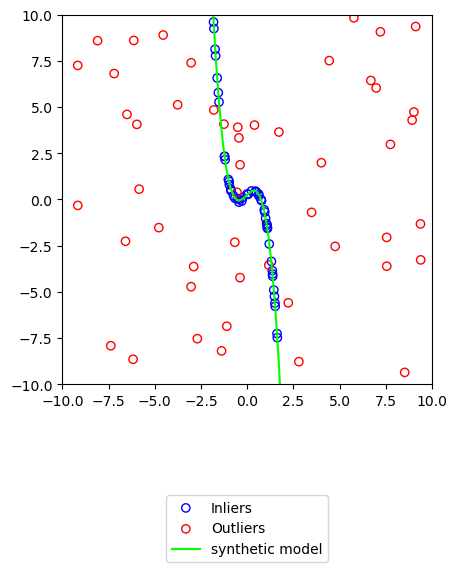

In [7]:
def plot_models(ax, inliers, outliers, synth_model: Polynomial, estimated_model: Optional[Polynomial] = None, title = None):
    ax.scatter(inliers[:, 0], inliers[:, 1], label="Inliers", c='none', edgecolors='blue')
    if outliers is not None:
        ax.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", c='none', edgecolors='red')
    
    x = np.linspace(-10, 10, 100)[:, None]
    if estimated_model is not None:
        y = estimated_model.evaluate(x)
        ax.plot(x, y, color='black', label="estimated model")
        
    if title is not None:
        ax.set_title(title)
        
    y = synth_model.evaluate(x)
    ax.plot(x, y, color='lime', label='synthetic model')
    
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.5), loc="lower center")

# Plotting the ground truth inliers/outliers 
poly_a = Polynomial(np.array([-2, -0.25, 1, 0.25]))
inliers, outliers = poly_a.generate_points(0.5)
fig, ax = plt.subplots()
plot_models(ax, inliers, outliers, poly_a)
plt.show()
plt.close(fig)

In [8]:
%%time
# A simple non-complete test case for the data generation part
# It should not take more than a few seconds to run it.

test_points = np.array([[-5.01341822, -7.11485119],
                        [ 1.86544097,  2.59891622],
                        [-0.37093626, -1.7499924 ],
                        [-7.8621905 , -0.45595404]])

inliers, outliers = poly_a.generate_points(0.5, 1000000)
assert poly_a.is_inlier(inliers).all(), "Bad inliers"
assert (~poly_a.is_inlier(outliers)).all(), "Bad outliers"
assert np.abs(inliers).max() <= D, "Inliers outside of the domain"
assert np.abs(outliers).max() <= D, "Outliers outside of the domain"

assert (poly_a.is_inlier(test_points) == np.array([*([True] * 3), False])).all(), "Failed test case"

AssertionError: Failed test case

In [ ]:
# Visualizing `fit` implementation. No need to edit this
def plot_fitted_poly(points, poly):
    fig, ax = plt.subplots()
    plot_models(ax, points, points[:0], poly)
    ax.get_legend().remove()
    plt.show()
    plt.close(fig)
    
poly = Polynomial.fit(test_points)

plot_fitted_poly(test_points, poly)

### 1.2. RANSAC

In [ ]:
def get_ransac_iterations(r: float, sample_size: int, p: float) -> int:
    """
    r - outlier ratio
    sample_size - minimum data
    p - success rate
    
    Returns - number of RANSAC iterations to achieve `p` success rate 
    """
    n = 1
    
    # TODO : Compute the minimum number of RANSAC iterations necessary to achieve `p` success rate
    # START 

    # END 
    
    return n

In [ ]:
def run_ransac(points: np.ndarray, n_iter: int, sample_size: int) -> Tuple[np.ndarray, np.ndarray, Polynomial]:
    """
    points - Nx2 array with the data points
    n_iter - number of ransac iterations
    sample_size - number of samples required to fit the model
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the final Polynomial model
    """

    n_points = points.shape[0]
    inliers = points[:0]
    outliers = points
    poly = None
    
    # TODO : Implement 1.2 - RANSAC for model fitting
    # START

    # END 
    
    return inliers, outliers, poly

In [ ]:
# Running RANSAC and populating historgrams
# It may take some time to run, you can adjust N_RUNS to help with debugging
N_RUNS = 1000
OUTLIER_RATIOS = [0.05, 0.2, 0.3, 0.7]

def plot_ransac_results(synth_poly: Polynomial):
    fig, axes = plt.subplots(2, len(OUTLIER_RATIOS), figsize=(17, 7))

    for r, (ax_hist, ax_vis) in zip(OUTLIER_RATIOS, zip(*axes)): 
        inlier_histogram = np.zeros(N_RUNS)

        ransac_inliers = None
        ransac_outliers = None
        model = None

        # TODO : Fill `inlier_histogram` array and assign `ransac_inliers`,
        #        `ransac_outliers`, `model`
        # START

        # END

        ax_hist.hist(inlier_histogram, range=(0, N), bins=N+1)

        plot_models(ax_vis, ransac_inliers, ransac_outliers, synth_poly, model)

    plt.show()
    plt.close(fig)


plot_ransac_results(poly_a)

In [ ]:
poly_b = Polynomial(np.array([1, 1]))
plot_ransac_results(poly_b)

### 1.3. Exhaustive search

In [ ]:
def exhaustive_search(points: np.ndarray, sample_size) -> Tuple[np.ndarray, np.ndarray, Polynomial]:
    """
    points - Nx2 array with the data points
    sample_size - number of samples required to fit the model
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the best model
    """

    n_points = points.shape[0]

    inliers = points[:0]
    outliers = points
    model = None

    # TODO : Implement exhaustive search by trying all the combinations of minimal data points
    # START

    # END 
    
    return inliers, outliers, model

In [ ]:
# Running exhaustive search. No need to edit this. Running on a reduced set of points
inliers, outliers = poly_a.generate_points(0.2, 30)
points = np.concatenate((inliers, outliers), 0)

sample_size = poly_a.degree + 1
n_iter = get_ransac_iterations(0.2, sample_size, 0.99)
ransac_inliers, ransac_outliers, ransac_model = run_ransac(points, n_iter, sample_size)

exhaustive_inliers, exhaustive_outliers, exhaustive_model = exhaustive_search(points, sample_size)

print(f"Real inliers: {len(inliers)}")
print(f"RANSAC inliers: {len(ransac_inliers)}")
print(f"Exhaustive search inliers: {len(exhaustive_inliers)}")

fig, axes = plt.subplots(1, 2, figsize=(17, 7))

plot_models(axes[0], ransac_inliers, ransac_outliers, poly_a, ransac_model)
plot_models(axes[1], exhaustive_inliers, exhaustive_outliers, poly_a, exhaustive_model)

plt.show()
plt.close(fig)

### Questions and Discussion 

<b style="color:red"> Question 1.1: </b> How many combinations (exhaustive search) exist for $N=100$ points? 

_TODO_: Your answer here

<b style="color:red"> Question 1.2: </b> What about the number of RANSAC iterations with $r=5\%$, $20\%$, $30\%$ and $70\%$? 

_TODO_: Your answer here

<b style="color:red"> Question 1.3: </b> What about when $N=100,000$ points?

_TODO_: Your answer here

<b style="color:red"> Question 1.4: </b> Does exhaustive search on all the combinations of data points guarantee the optimal solution (in terms of number of inliers)? Why?

_TODO_: Your answer here

<b style="color:red"> Question 1.5: </b> Does RANSAC always find close to the optimal number of inliers? Why? If not, would increasing the number of RANSAC iterations always improve that?

_TODO_: Your answer here

<b style="color:red"> Question 1.6: </b> Discuss and compare the results obtained by RANSAC and exhaustive search in terms of
number of inliers, speed, number of synthesized inliers, etc.

_TODO_: Your answer here

<b style="color:red"> Question 1.7: </b> One of the challenges in using RANSAC for fitting polynomials is choosing appropriate values for the number of iterations and the inlier threshold. How would you go about selecting these values, and what factors should you consider when making this choice? Describe any tradeoffs that may exist between these two parameters, and provide an example scenario where a higher number of iterations or a higher inlier threshold might be preferable.

_TODO_: Your answer here

## Part 2: IRLS and norms for line fitting

In [ ]:
poly_b = Polynomial(np.array([1, 1]))

In [ ]:
# Plotting the generated line that will be used for model fitting, no need to change this code    
inliers, outliers = poly_b.generate_points(0.1)
points = np.concatenate((inliers, outliers), 0)

fig, ax = plt.subplots()
plot_models(ax, inliers, outliers, poly_b)
plt.show()
plt.close(fig)

In [ ]:
## Implement different line fitting algorithms

def fit_line_irls_l1(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    
    line = np.array([0, 0.5])
    
    # TODO : Implement line fitting with L-1 norm by using IRLS
    # START

    # END

    return Polynomial(line)


def fit_line_lp_l1(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """   
    line = np.array([0, 0.5])

    # TODO : Implement line fitting with L-1 norm by using linear programming
    # START

    # END
    
    return Polynomial(line)


def fit_line_lp_l_inf(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    line = np.array([0, 0.5])
    
    # TODO : Implement line fitting with L-infinity norm by using linear programming
    # START

    # END
    
    return Polynomial(line)

In [ ]:
# Plotting the results. No need to change this code
for r in [0.0, 0.01, 0.1, 0.5, 0.8]:
    inliers, outliers = poly_b.generate_points(r)
    points = np.concatenate((inliers, outliers), 0)

    irls_l1_line = fit_line_irls_l1(points)
    lp_l1_line = fit_line_lp_l1(points)
    lp_l_inf_line = fit_line_lp_l_inf(points)

    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    
    fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)
    
    plot_models(axes[0], inliers, outliers, poly_b, irls_l1_line, title="L1 IRLS")
    plot_models(axes[1], inliers, outliers, poly_b, lp_l1_line, title="L1 IRLS")
    plot_models(axes[2], inliers, outliers, poly_b, lp_l_inf_line, title="L-inf LP")
    
    plt.show()
    plt.close(fig)
    
    print(f"IRLS L1: {irls_l1_line}")
    print(f"LP L1: {lp_l1_line}")
    print(f"LP L-inf: {lp_l_inf_line}")


In [ ]:
# Comparison with RANSAC
r = 0.8
inliers, outliers = poly_b.generate_points(r)
points = np.concatenate((inliers, outliers), 0)

sample_size = poly_b.degree + 1
n_iter = get_ransac_iterations(r, sample_size, 0.99)
_, _, ransac_line = run_ransac(points, n_iter, sample_size)

lp_l1_line = fit_line_lp_l1(points)
lp_l_inf_line = fit_line_lp_l_inf(points)

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    
fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)
    
plot_models(axes[0], inliers, outliers, poly_b, ransac_line, title="RANSAC")
plot_models(axes[1], inliers, outliers, poly_b, lp_l1_line, title="L1")
plot_models(axes[2], inliers, outliers, poly_b, lp_l_inf_line, title="L-inf")
    
plt.show()
plt.close(fig)

### Discussion 

<b style="color:red"> Question 2.1:</b> Discuss the results obtained by IRLS/LP solutions.

_TODO_: Your answer here

<b style="color:red"> Question 2.2:</b> Compare and contrast them with RANSAC. What are the key differences between these two approaches? Under what circumstances might one be more suitable than the other?

_TODO_: Your answer here